<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_4/capstone/4_5b_model_selection_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My Fellow Citizens:
#### Natural Language Processing Model of Inaugural Addresses

### Table of Contents
1. Preprocessing
    - Import Data and Packages
    - EDA
    - Feature Engineering
    - Clean Data
    - Parse Data
2. Feature Extraction
    - Bag of Words
    - Tf-idf
3. Model Selection
    - Split Test/Training Data
    - Clustering
        - K-Means
        - Mean Shift
        - Spectral Clustering
        - Affinity Propagation
    - Supervised Learning
        - L1/l2 Regression
        - Random Forest
        - Support Vector Machine
    - Assessment
4. Model Tuning
    - Dimensionality Reduction
    - Supervised/Unsupervised Model Comparrison
5. Conclusion

### Import data and packages

In [0]:
# load packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

#from sklearn.metrics import silhouette_score
#from sklearn.model_selection import cross_val_score

In [2]:
filename = 'inaugural'
df_prez = pd.read_csv(filename+".csv", index_col=0)
df_prez.head()

,fileid,target,era,year,president,party,recession,wartime,text_raw,length_raw,text_clean,length_clean,text_parsed,length_parsed,text_nostops,length_nostops
0,1789-Washington.txt,NaN,founding,1789,washington,federalist,0,0,Fellow-Citizens of the Senate and of the House...,8619,fellow citizens of the senate and of the house...,8427,"['fellow', 'citizen', 'of', 'the', 'senate', '...",1394,"['fellow', 'citizen', 'senate', 'house', 'repr...",579
1,1793-Washington.txt,NaN,founding,1793,washington,federalist,0,0,"Fellow citizens, I am again called upon by the...",791,fellow citizens am again called upon by the vo...,763,"['fellow', 'citizen', 'be', 'again', 'call', '...",129,"['fellow', 'citizen', 'call', 'voice', 'countr...",56
2,1797-Adams.txt,NaN,founding,1797,adams,federalist,0,0,"When it was first perceived, in early times, t...",13877,when it was first perceived in early times tha...,13473,"['when', '-PRON-', 'be', 'first', 'perceive', ...",2257,"['perceive', 'early', 'time', 'middle', 'cours...",976
3,1801-Jefferson.txt,NaN,founding,1801,jefferson,democratic-republican,0,0,Friends and Fellow Citizens:\n\nCalled upon to...,10137,friends and fellow citizens called upon to und...,9835,"['friend', 'and', 'fellow', 'citizen', 'call',...",1688,"['friend', 'fellow', 'citizen', 'call', 'under...",723
4,1805-Jefferson.txt,NaN,founding,1805,jefferson,democratic-republican,0,0,"Proceeding, fellow citizens, to that qualifica...",12908,proceeding fellow citizens to that qualificati...,12598,"['proceed', 'fellow', 'citizen', 'to', 'that',...",2128,"['proceed', 'fellow', 'citizen', 'qualificatio...",902


In [3]:
filename = 'inaugural_word_counts'
word_counts = pd.read_csv(filename+".csv", index_col=0)
word_counts.head()

,fileid,text_nostops,government,people,nation,state,great,country,world,power,shall,citizen,time,law,right,peace,good,new,man,american,public,america,duty,constitution,war,free,interest,freedom,united,union,life,year,hope,national,principle,know,let,fellow,work,spirit,...,scope,relative,faction,occasionally,widen,dependence,abolish,columbia,fullness,overcome,probably,uniform,betray,monarchy,complain,potent,strange,mischief,minister,corner,absence,clothe,joint,prudent,accession,inform,temple,annual,asia,levy,economical,rightfully,consume,opening,unmindful,active,sorrow,furnace,justification,channel
0,1789-Washington.txt,"['fellow', 'citizen', 'senate', 'house', 'repr...",9,4,3,2,4,5,1,2,3,5,1,0,2,0,3,1,1,2,6,0,5,1,0,2,1,0,4,2,1,1,2,1,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1793-Washington.txt,"['fellow', 'citizen', 'call', 'voice', 'countr...",1,1,0,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1797-Adams.txt,"['perceive', 'early', 'time', 'middle', 'cours...",18,20,20,12,5,10,3,6,4,6,3,2,2,5,7,1,4,3,6,5,3,9,1,2,4,0,3,2,2,5,1,4,3,0,0,3,0,6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1801-Jefferson.txt,"['friend', 'fellow', 'citizen', 'call', 'under...",13,2,4,3,4,4,3,5,6,7,0,4,6,5,8,0,9,0,4,0,2,2,1,3,0,4,0,2,1,0,2,0,9,1,7,7,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1805-Jefferson.txt,"['proceed', 'fellow', 'citizen', 'qualificatio...",3,0,6,12,1,5,2,4,7,10,6,6,4,4,4,1,3,1,14,0,8,6,4,1,8,2,1,3,2,4,0,0,4,2,2,8,1,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
filename = 'inaugural_tf_idf'
tf_idf = pd.read_csv(filename+".csv", index_col=0)
tf_idf.head()

,fileid,text_nostops,abandon,abandonment,abide,ability,able,abode,abolish,aboriginal,abound,abraham,abreast,abroad,absence,absent,absolute,absolutely,absorb,abstain,abundance,abundant,abundantly,abuse,accept,acceptance,access,accessible,accession,accident,accommodation,accompany,accomplish,accomplishment,accord,accordance,accordingly,account,accountability,accountable,...,wind,window,winter,wipe,wise,wisely,wish,withdraw,wither,withhold,witness,woman,womanhood,wonder,wonderful,word,worker,workingman,worldly,worldwide,worship,worth,worthily,worthy,wound,wrest,writ,write,writer,wrong,yearn,yes,yesterday,yield,yorktown,young,youth,zeal,zealous,zealously
0,1789-Washington.txt,"['fellow', 'citizen', 'senate', 'house', 'repr...",0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033835,0.0,0.000000,0.0,0.06622,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.061866,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,1793-Washington.txt,"['fellow', 'citizen', 'call', 'voice', 'countr...",0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.163159,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,1797-Adams.txt,"['perceive', 'early', 'time', 'middle', 'cours...",0.030996,0.0,0.0,0.0,0.000000,0.0,0.0,0.040534,0.0,0.0,0.0,0.026315,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.029231,0.0,0.0,0.0,0.0,0.0,0.049085,0.0,0.0,0.000000,0.0,0.029231,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.022929,0.0,0.067335,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035532,0.0,0.0
3,1801-Jefferson.txt,"['friend', 'fellow', 'citizen', 'call', 'under...",0.040103,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.034046,0.0,0.0,0.045972,0.0,0.0,0.0,0.0,0.0,0.0,0.075637,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.037819,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.029665,0.0,0.029039,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.052443,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035821,0.0,0.059331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045972,0.0,0.0
4,1805-Jefferson.txt,"['proceed', 'fellow', 'citizen', 'qualificatio...",0.000000,0.0,0.0,0.0,0.030152,0.0,0.0,0.041811,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.060303,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.030152,0.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.023152,0.0,0.0,0.0,0.087991,0.0,0.0,0.0,0.000000,0.023651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028559,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109956,0.0,0.0


In [0]:
# set data for modeling
Data_bow = word_counts.drop(['fileid', 'text_nostops'], 1)
Data_tfidf = tf_idf.drop(['fileid', 'text_nostops'], 1)
df = pd.concat([word_counts, tf_idf.drop(['fileid', 'text_nostops'], axis=1)], axis=1)
Data = df.drop(['fileid', 'text_nostops'], axis=1)

## Unsupervised Models

In [0]:
# define dataframes to store results
cluster_desc = pd.DataFrame()
cluster_score = pd.DataFrame()

# define supervised modeling function
def unsupervised_clf(model, data, target, test_size=0.25, stratify=None):
  """
  """
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import silhouette_score, adjusted_rand_score
  
  X_train, X_test, y_train, y_test = train_test_split(
      data, target, test_size=test_size, stratify=stratify, random_state=42)
  
  # silhouette score
  sil_scores = []
  for sample in [X_train, X_test]:
    model.fit(sample)
    labels = model.labels_
    sil_score = silhouette_score(sample, labels, metric='euclidean')
    sil_scores.append(sil_score)
  
  sil_var = np.round(np.var(sil_scores)*100, 4)
  train_sil = np.round(sil_scores[0]*100, 4)
  test_sil = np.round(sil_scores[1]*100, 4)
  print('\nTraining silhouette score:', train_sil)
  print('\nValidation silhouette score:', test_sil)
  print('\nSilhouette score variance:', sil_var)
  
  #rand index
  model.fit(data)
  ARI = np.round(adjusted_rand_score(target, model.labels_), 4)
  print("\nAdjusted rand index variance :", ARI)
  
  return pd.DataFrame([[train_sil, test_sil, sil_var, ARI]],
                      columns=["train_sil_score", "test_sil_score", "sil_var", "ARI"])

### Modeling Recessions

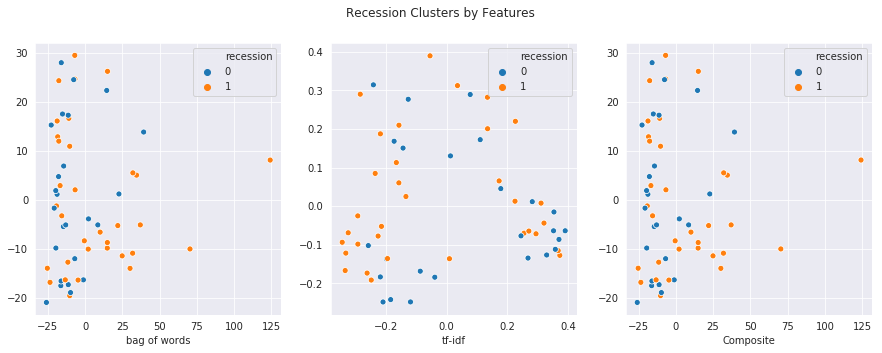

In [7]:
from sklearn.decomposition import PCA
# reduce data to two dimensions
bow_2D = PCA(n_components=2).fit_transform(Data_bow)
tfidf_2D = PCA(n_components=2).fit_transform(Data_tfidf)
data_2D = PCA(n_components=2).fit_transform(Data)

data_list = [bow_2D, tfidf_2D, data_2D]
labels_list = [df_prez['recession'], df_prez['recession'], df_prez['recession']]

def plotting_func(labels_list, data_list=[], num_plots=3, title="placeholder"):
  """
  """
  num_plots = range(0,num_plots)
  
  # plot target variable
  fig, axes = plt.subplots(1, len(num_plots), figsize=(15,5))

  sns.scatterplot(data_list[0][:,0], data_list[0][:,1],
                  hue=labels_list[0], ax=axes[num_plots[0]])
  axes[0].set_xlabel("bag of words")

  sns.scatterplot(data_list[1][:,0], data_list[1][:,1],
                  hue=labels_list[1], ax=axes[num_plots[1]])
  axes[1].set_xlabel("tf-idf")

  sns.scatterplot(data_list[-1][:,0], data_list[-1][:,1],
                  hue=labels_list[-1], ax=axes[num_plots[-1]])
  axes[2].set_xlabel("Composite")

  fig.suptitle(title+" Clusters by Features")
  plt.show;
  
# plot recession target variable
plotting_func(labels_list, data_list, 3, "Recession")

#### K-Means

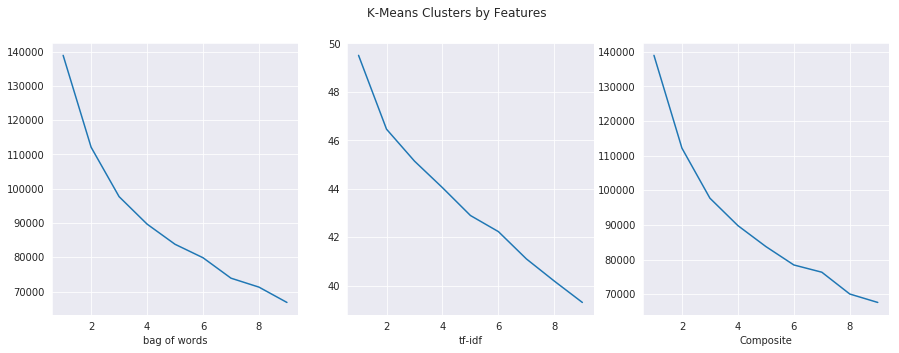

In [8]:
from sklearn.cluster import KMeans

# Run the Kmeans algorithm and get the index of data points clusters
inertia_bow = []
inertia_tfidf = []
inertia_data = []
k_range = list(range(1, 10))

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    inertia_bow.append(kmeans.fit(Data_bow).inertia_)
    inertia_tfidf.append(kmeans.fit(Data_tfidf).inertia_)
    inertia_data.append(kmeans.fit(Data).inertia_)

# plot recession target variable
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.lineplot(k_range, inertia_bow, ax=axes[0])
axes[0].set_xlabel("bag of words")

sns.lineplot(k_range, inertia_tfidf, ax=axes[1])
axes[1].set_xlabel("tf-idf")

sns.lineplot(k_range, inertia_data, ax=axes[2])
axes[2].set_xlabel("Composite")

fig.suptitle("K-Means Clusters by Features")
plt.show;

In [9]:
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto', random_state=42)
bow_labels = kmeans.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: kmeans


Training silhouette score: 27.642

Validation silhouette score: 27.3636

Silhouette score variance: 0.0002

Adjusted rand index variance : 0.0124


In [10]:
tfidf_labels = kmeans.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: kmeans


Training silhouette score: 4.8383

Validation silhouette score: 3.2437

Silhouette score variance: 0.0064

Adjusted rand index variance : 0.0018


In [11]:
data_labels = kmeans.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: kmeans


Training silhouette score: 27.633

Validation silhouette score: 27.3535

Silhouette score variance: 0.0002

Adjusted rand index variance : 0.0124


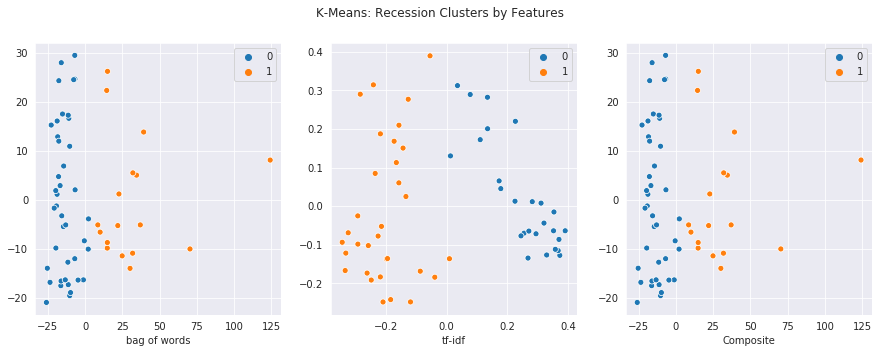

In [12]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "K-Means: Recession")

#### Mean Shift

In [15]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth_bow = estimate_bandwidth(Data_bow, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_bow)
bow_labels = meanshift.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: mean shift


Training silhouette score: 16.1678

Validation silhouette score: 18.7787

Silhouette score variance: 0.017

Adjusted rand index variance : -0.0301


In [16]:
bandwidth_tfidf = estimate_bandwidth(Data_tfidf, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_tfidf)
tfidf_labels = meanshift.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: mean shift



ValueError: ignored

In [17]:
bandwidth_data = estimate_bandwidth(Data, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_data)
data_labels = meanshift.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: mean shift


Training silhouette score: 16.1588

Validation silhouette score: 18.7695

Silhouette score variance: 0.017

Adjusted rand index variance : -0.0301


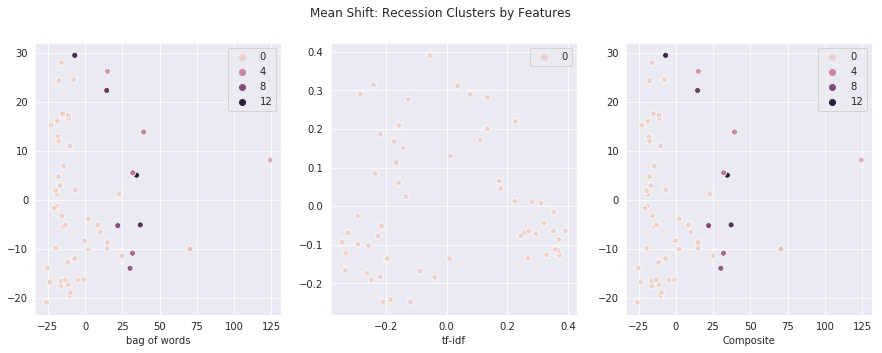

In [18]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "Mean Shift: Recession")

#### Spectral Clustering

In [19]:
from sklearn.cluster import SpectralClustering
spec = SpectralClustering(n_clusters=2)
bow_labels = spec.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: spectral



/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.6/dist-packages/s

ValueError: ignored

In [20]:
tfidf_labels = spec.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: spectral


Training silhouette score: 4.8383

Validation silhouette score: 3.0084

Silhouette score variance: 0.0084

Adjusted rand index variance : 0.0018


In [21]:
data_labels = spec.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: spectral



/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.6/dist-packages/s

ValueError: ignored

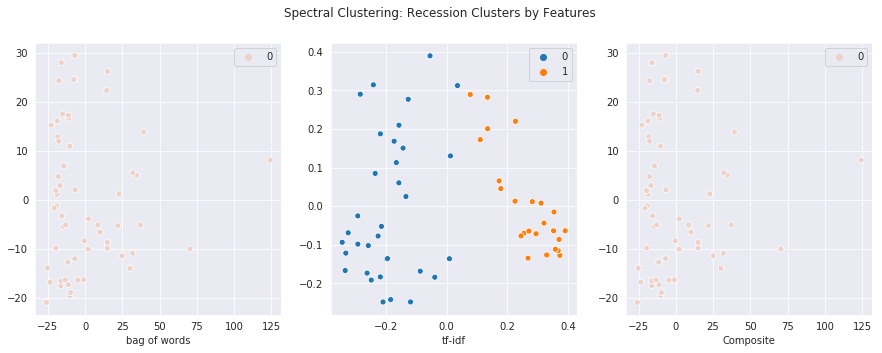

In [22]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "Spectral Clustering: Recession")

#### Affinity Propagation

In [23]:
from sklearn.cluster import AffinityPropagation
aff = AffinityPropagation()
bow_labels = aff.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: affinity


Training silhouette score: 8.1969

Validation silhouette score: 18.7787

Silhouette score variance: 0.2799

Adjusted rand index variance : -0.0276


In [24]:
tfidf_labels = aff.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: affinity


Training silhouette score: 1.0037

Validation silhouette score: 2.8926

Silhouette score variance: 0.0089

Adjusted rand index variance : -0.0175


In [25]:
data_labels = aff.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: affinity


Training silhouette score: 8.1936

Validation silhouette score: 18.7695

Silhouette score variance: 0.2796

Adjusted rand index variance : -0.0276


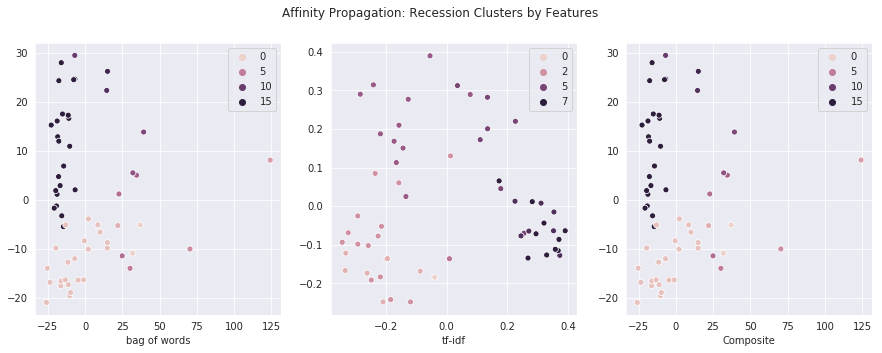

In [26]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "Affinity Propagation: Recession")

#### Agglormerative Clustering

In [27]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=2)
bow_labels = agg.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: agglomerative


Training silhouette score: 8.1969

Validation silhouette score: 18.7787

Silhouette score variance: 0.2799

Adjusted rand index variance : -0.0276


In [28]:
tfidf_labels = agg.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: agglomerative


Training silhouette score: 1.0037

Validation silhouette score: 2.8926

Silhouette score variance: 0.0089

Adjusted rand index variance : -0.0175


In [29]:
data_labels = agg.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: agglomerative


Training silhouette score: 8.1936

Validation silhouette score: 18.7695

Silhouette score variance: 0.2796

Adjusted rand index variance : -0.0276


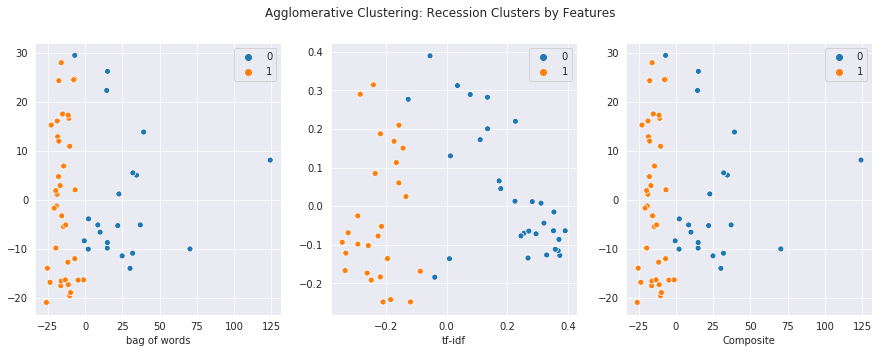

In [30]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "Agglomerative Clustering: Recession")

#### DBSCAN

In [31]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()
bow_labels = dbscan.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "bag of words", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data_bow,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: bag of words
Model: DBSCAN



ValueError: ignored

In [32]:
tfidf_labels = dbscan.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "tf-idf", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data_tfidf,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: tf-idf
Model: DBSCAN



ValueError: ignored

In [33]:
data_labels = dbscan.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["recession", "composite", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data,
                                                      df_prez['recession'],
                                                      stratify=df_prez['recession']),
                                     ignore_index=True)

Target: recession
Features: composite
Model: DBSCAN



ValueError: ignored

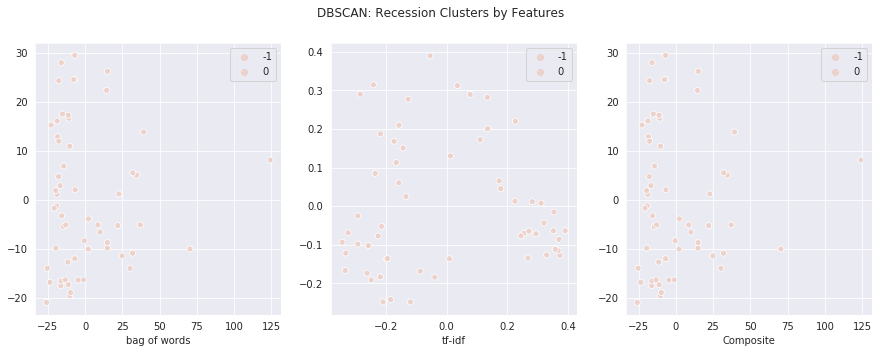

In [34]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "DBSCAN: Recession")

### Modeling Wartime

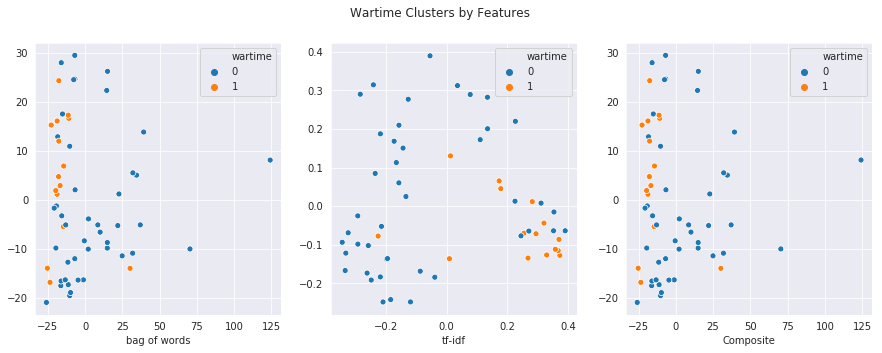

In [35]:
label_list = [df_prez['wartime'], df_prez['wartime'], df_prez['wartime']]
plotting_func(label_list, data_list, 3, "Wartime")

#### K-Means

In [36]:
kmeans = KMeans(n_clusters=2, max_iter=600, algorithm = 'auto', random_state=42)
bow_labels = kmeans.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: kmeans


Training silhouette score: 58.5871

Validation silhouette score: 25.1813

Silhouette score variance: 2.7899

Adjusted rand index variance : -0.0526


In [37]:
tfidf_labels = kmeans.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: kmeans


Training silhouette score: 4.5474

Validation silhouette score: 3.8399

Silhouette score variance: 0.0013

Adjusted rand index variance : 0.2207


In [38]:
data_labels = kmeans.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "kmeans"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(kmeans,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: kmeans


Training silhouette score: 58.5784

Validation silhouette score: 25.1731

Silhouette score variance: 2.7898

Adjusted rand index variance : -0.0526


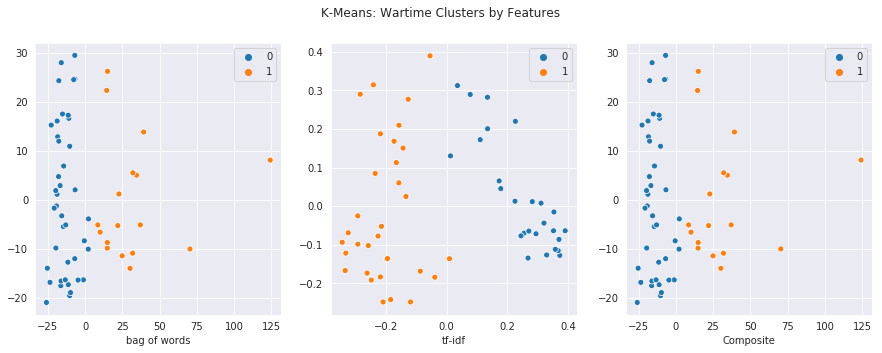

In [39]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "K-Means: Wartime")

#### Mean Shift

In [40]:
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth_bow = estimate_bandwidth(Data_bow, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_bow)
bow_labels = meanshift.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: mean shift


Training silhouette score: 18.1465

Validation silhouette score: 19.0942

Silhouette score variance: 0.0022

Adjusted rand index variance : -0.1131


In [41]:
bandwidth_tfidf = estimate_bandwidth(Data_tfidf, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_tfidf)
tfidf_labels = meanshift.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: mean shift



ValueError: ignored

In [42]:
bandwidth_data = estimate_bandwidth(Data, quantile=0.3)
meanshift = MeanShift(bandwidth=bandwidth_data)
data_labels = meanshift.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "mean shift"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(meanshift,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: mean shift


Training silhouette score: 18.1373

Validation silhouette score: 19.0855

Silhouette score variance: 0.0022

Adjusted rand index variance : -0.1131


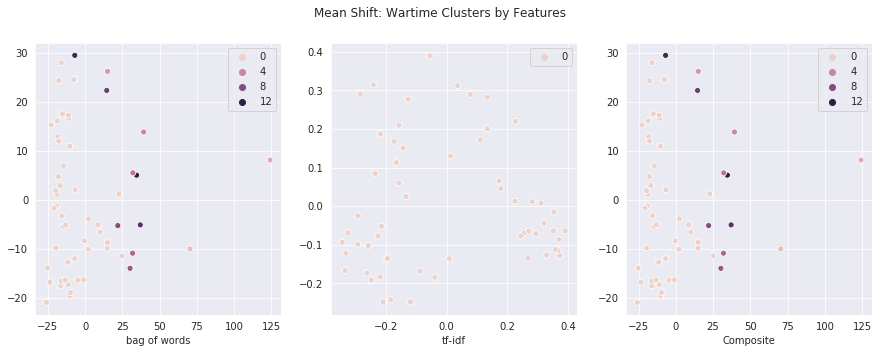

In [43]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "Mean Shift: Wartime")

#### Spectral Clustering

In [44]:
from sklearn.cluster import SpectralClustering
spec = SpectralClustering(n_clusters=2)
bow_labels = spec.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: spectral



/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.6/dist-packages/s

ValueError: ignored

In [45]:
tfidf_labels = spec.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: spectral


Training silhouette score: 4.6159

Validation silhouette score: 4.1484

Silhouette score variance: 0.0005

Adjusted rand index variance : 0.2174


In [46]:
data_labels = spec.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "spectral"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(spec,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: spectral



/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/usr/local/lib/python3.6/dist-packages/s

ValueError: ignored

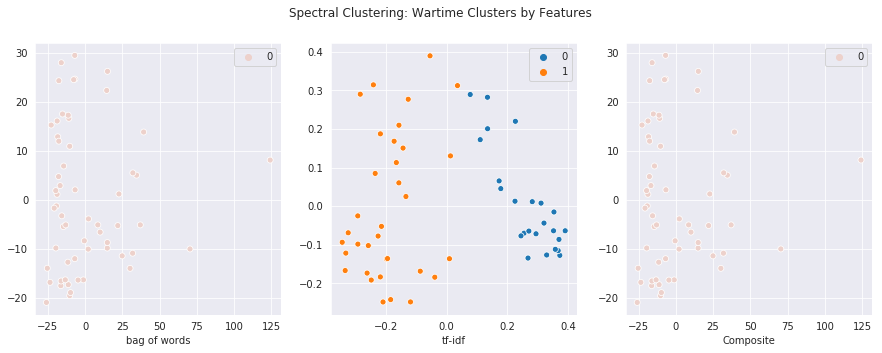

In [47]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "Spectral Clustering: Wartime")

#### Affinity Propagation

In [48]:
from sklearn.cluster import AffinityPropagation
aff = AffinityPropagation()
bow_labels = aff.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: affinity


Training silhouette score: 5.6027

Validation silhouette score: 19.0942

Silhouette score variance: 0.4551

Adjusted rand index variance : 0.0465


In [49]:
tfidf_labels = aff.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: affinity


Training silhouette score: 2.3072

Validation silhouette score: 4.4438

Silhouette score variance: 0.0114

Adjusted rand index variance : 0.1078


In [50]:
data_labels = aff.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "affinity"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: affinity


Training silhouette score: 5.5986

Validation silhouette score: 19.0855

Silhouette score variance: 0.4547

Adjusted rand index variance : 0.0465


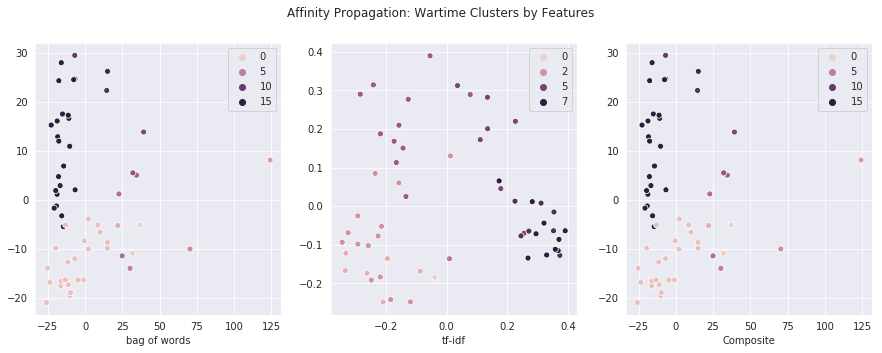

In [51]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "Affinity Propagation: Wartime")

#### Agglormerative Clustering

In [52]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=2)
bow_labels = agg.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: agglomerative


Training silhouette score: 5.6027

Validation silhouette score: 19.0942

Silhouette score variance: 0.4551

Adjusted rand index variance : 0.0465


In [53]:
tfidf_labels = agg.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: agglomerative


Training silhouette score: 2.3072

Validation silhouette score: 4.4438

Silhouette score variance: 0.0114

Adjusted rand index variance : 0.1078


In [54]:
data_labels = agg.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "agglomerative"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(aff,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: agglomerative


Training silhouette score: 5.5986

Validation silhouette score: 19.0855

Silhouette score variance: 0.4547

Adjusted rand index variance : 0.0465


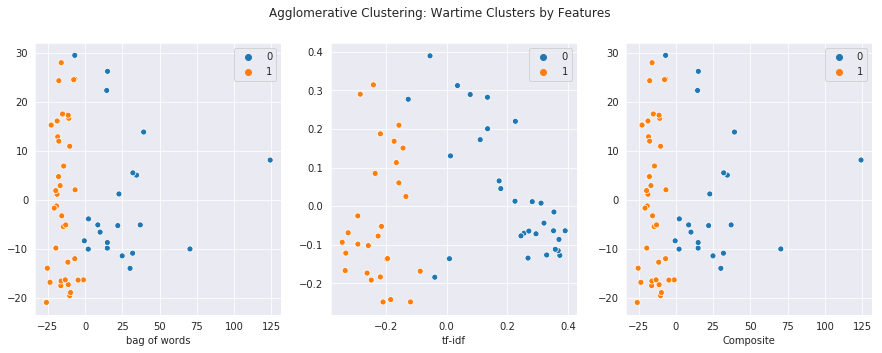

In [55]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "Agglomerative Clustering: Wartime")

#### DBSCAN

In [56]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()
bow_labels = dbscan.fit(Data_bow).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "bag of words", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data_bow,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: bag of words
Model: DBSCAN



ValueError: ignored

In [57]:
tfidf_labels = dbscan.fit(Data_tfidf).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "tf-idf", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data_tfidf,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: tf-idf
Model: DBSCAN



ValueError: ignored

In [58]:
data_labels = dbscan.fit(Data).labels_

cluster_desc = cluster_desc.append(pd.DataFrame([["wartime", "composite", "DBSCAN"]],
                                                columns=["target", "features", "model"]),
                                   ignore_index=True)

print("Target: {}\nFeatures: {}\nModel: {}\n".format(
    cluster_desc["target"].iloc[-1],
    cluster_desc["features"].iloc[-1],
    cluster_desc["model"].iloc[-1]))

cluster_score = cluster_score.append(unsupervised_clf(dbscan,
                                                      Data,
                                                      df_prez['wartime'],
                                                      stratify=df_prez['wartime']),
                                     ignore_index=True)

Target: wartime
Features: composite
Model: DBSCAN



ValueError: ignored

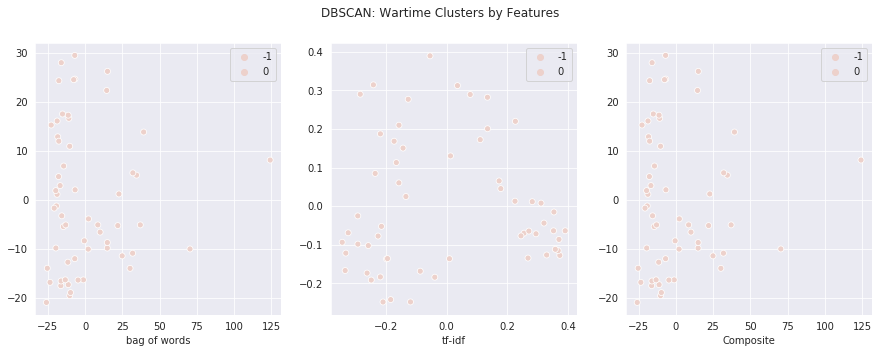

In [59]:
label_list = [bow_labels, tfidf_labels, data_labels]
plotting_func(label_list, data_list, 3, "DBSCAN: Wartime")

### Analysis

In [60]:
cluster_score.describe()

,train_sil_score,test_sil_score,sil_var,ARI
count,25.000000,25.000000,25.000000,25.00000
mean,13.514560,15.197884,0.345252,0.01204
std,15.496234,8.544251,0.756327,0.08217
min,1.003700,2.892600,0.000200,-0.11310
25%,4.838300,4.443800,0.006400,-0.03010
50%,8.193600,18.778700,0.017000,-0.01750
75%,16.167800,19.094200,0.279900,0.04650
max,58.587100,27.363600,2.789900,0.22070


In [61]:
df_test = pd.concat([cluster_desc, cluster_score], axis=1)
df_test.sort_values(by=["ARI"], ascending=False).head(10)

,target,features,model,train_sil_score,test_sil_score,sil_var,ARI
14,recession,bag of words,agglomerative,4.5474,3.8399,0.0013,0.2207
18,recession,tf-idf,DBSCAN,4.6159,4.1484,0.0005,0.2174
23,wartime,bag of words,mean shift,2.3072,4.4438,0.0114,0.1078
20,wartime,bag of words,kmeans,2.3072,4.4438,0.0114,0.1078
24,wartime,tf-idf,mean shift,5.5986,19.0855,0.4547,0.0465
22,wartime,composite,kmeans,5.6027,19.0942,0.4551,0.0465
21,wartime,tf-idf,kmeans,5.5986,19.0855,0.4547,0.0465
19,recession,composite,DBSCAN,5.6027,19.0942,0.4551,0.0465
0,recession,bag of words,kmeans,27.6420,27.3636,0.0002,0.0124
2,recession,composite,kmeans,27.6330,27.3535,0.0002,0.0124
